# MNIST DATA

We are working with MNIST data, a toy dataset to test algorithms on.

We have training data and test data.

**Basics**: 28 x 28 images of handwritten digits as well as the label of which digit $0 \leq label \leq 9.$

**Format**: label, pix-11, pix-12, pixe-13, pix-ij where the pixel is in the ith row and the jth column.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
# let's first start w. logistic regression
# read in the data
train = np.asarray(pd.read_csv('mnist_train.csv', header = None))
test = np.asarray(pd.read_csv('mnist_test.csv', header = None))

In [3]:
# split the features from the prediction values
xTrain = train[:,1:] 
xTrain = xTrain 
yTrain = train[:,0].reshape(-1,1) 
yTrain = yTrain

xTest = test[:,1:]
yTest = test[:,0].reshape(-1,1)


In [4]:
print("The number of samples in the training set for 0s and 1s is {}".format(train.shape))
print("The number of samples in the x training set for 0s and 1s is {}".format(xTrain.shape))
print("The number of samples in the y training set for 0s and 1s is {}".format(yTrain.shape))

print("The number of samples in the test set for 0s and 1s is {}".format(test.shape))
print("The number of samples in the x test set for 0s and 1s is {}".format(xTest.shape))
print("The number of samples in the y test set for 0s and 1s is {}".format(yTest.shape))

The number of samples in the training set for 0s and 1s is (60000, 785)
The number of samples in the x training set for 0s and 1s is (60000, 784)
The number of samples in the y training set for 0s and 1s is (60000, 1)
The number of samples in the test set for 0s and 1s is (10000, 785)
The number of samples in the x test set for 0s and 1s is (10000, 784)
The number of samples in the y test set for 0s and 1s is (10000, 1)


Now, we create gradient descent from a log-likehood estimate, hence we find the equation
$$ \theta_j := \theta_j + \alpha \frac{\partial l}{\partial \theta}$$
where 
$$ \frac{\partial l}{\partial \theta} =  y-\sigma(\theta^T x)x_i + \alpha \theta$$
where 
$$ \sigma(\theta^T x) = \frac{1}{1+e^{-\theta^T x}}$$


In [5]:
from sklearn.preprocessing import OneHotEncoder
from scipy.misc import logsumexp

In [6]:
def softmax(X):
    # follows the softmax function of exp/ sum(exp) but also normalizes the values because they are too big
    return np.exp(X - np.max(X, axis=1)) / np.sum(np.exp(X - np.max(X, axis=1)), axis=1)

In [7]:
def log_softmax(X):
    # normalizes values futher
    return X - logsumexp(X, axis=1)

In [8]:
def log_likelihood(X, y_ones, classes, alp=1e-6):
    mu = X @ classes
    # essentiall we just take the weights and use 1 and 0 methods
    # the ij to ji portion is just converting the values in the matrices
    return np.sum(mu[y_ones] - logsumexp(mu, axis=1),) - alp*np.einsum('ij,ji->', classes.T, classes)/2

In [29]:
def grad_log_likelihood(X, y_ones, classes, alp=1e-6):
    # Notice that we can use y_ones because the term is generalized for softmax regression
    mu = np.exp(X @ classes - np.max(X @ classes, axis=1)[:,np.newaxis]) # we make sure to normalize the large values
    mu = mu / np.sum(mu, axis=1)[:,np.newaxis]
    return X.T @ (mu - y_ones) + alp*classes

In [96]:

# use larger batch sizes to have a smoother curve.
def softmax_grad(X, y, lammy=1e-6, eps=1e-12,  alp=1000, max_iters=1000, batch_size=256):
    enc = OneHotEncoder()
    y_ones = enc.fit_transform(yTrain.copy().reshape(-1,1),).astype(bool).toarray()
    print(y_ones.shape)
    classes = np.zeros((X.shape[1], y_ones.shape[1])) #set initial class weights as 0
    
    reasonable_weights =[]
    # get the intial class likelihood 
    idx = np.random.randint(0, X.shape[0], size=batch_size)
    outputs = [log_likelihood(X[idx], y_ones[idx], classes, alp)]
    print(outputs[0])
    grad = grad_log_likelihood(X[idx], y_ones[idx], classes, alp)
    
    # reiterate through to generate the rest of the likelihoods. 
    while len(outputs)-1 <= max_iters and np.linalg.norm(grad) > eps:
        if len(outputs) % 200 == 0:
            print(len(outputs))
        idx = np.random.randint(0, X.shape[0], size=batch_size)
        grad = grad_log_likelihood(X[idx], y_ones[idx], classes, alp)
        classes = classes - lammy * grad
        llhood = log_likelihood(X[idx], y_ones[idx], classes, alp)
        outputs.append(llhood)
        reasonable_weights.append(classes)
        if llhood > -150:
            print(llhood)
    return classes, outputs, reasonable_weights

In [80]:
w, outs, weight1 = softmax_grad(xTrain, yTrain)

(60000, 10)
-589.461783806
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500


In [84]:
theIndex = outs.index(max(outs))
print(outs.index(max(outs)))
print(outs[theIndex])
print(weight1[theIndex])

358
-155.190292105
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [85]:
predicate = xTrain @ weight1[theIndex]
acc = (np.argmax(predicate, axis = 1).reshape(-1,1)== yTrain).mean()
print(acc)
# Hence, we find an accuracy of 89.73%, which we round to 90%

0.8973


[0 0 4 ..., 0 0 0]
(60000,)


In [49]:
newt_iters = []
newt_vals = []
for i, val in enumerate(outs[:]):
    newt_iters.append(i)
    newt_vals.append(val)

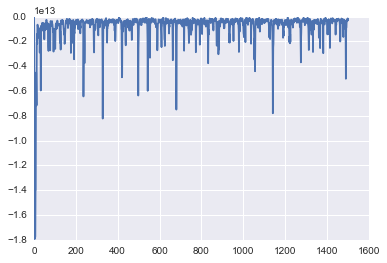

In [40]:
plt.plot(newt_iters, newt_vals)

In [97]:
iters = []
accs =[]
for vals in np.linspace(0,1000, 100):
    w, outs, weight1 = softmax_grad(xTrain, yTrain, alp = vals)
    theIndex = outs.index(max(outs))
    predicate = xTrain @ weight1[theIndex]
    acc = (np.argmax(predicate, axis = 1).reshape(-1,1)== yTrain).mean()
    iters.append(vals)
    accs.append(acc)

(60000, 10)
-589.461783806
200
-113.841179274
-126.844839183
-87.67892096
400
-142.065800872
-145.505940245
600
-104.864041922
-133.446280426
-106.684790452
-121.741427044
-127.988513602
800
-140.899674333
-90.0968342974
-117.36724934
-99.0570295203
-141.237979027
-146.49211318
-119.027459538
1000
(60000, 10)
-589.461783806
-98.7033955948
200
-136.036713745
-122.314995964
-84.431769144
-114.544634106
-82.3951206641
-91.0471474083
-126.648098176
-69.0747665805
400
-147.933150706
-145.292619651
600
-122.773406212
-81.8649704235
-69.459185702
-124.928733
-113.665455383
-113.790764342
-127.063046497
-80.1555940217
-116.086217249
800
-135.18835965
-137.500744804
-133.703973424
1000
(60000, 10)
-589.461783806
200
-139.08574539
400
-130.678264855
600
-130.454673741
-81.5310818588
-129.638318539
-137.059786887
-118.867547074
-143.079119345
800
-108.822878239
-148.978540428
-148.421585734
-127.08670512
-91.7771048151
-143.042089884
1000
(60000, 10)
-589.461783806
200
400
600
-99.1123930463
-138

In [98]:
print(accs.index(max(accs)))
print(iters[1])
print(max(accs))

3
10.101010101
0.91275


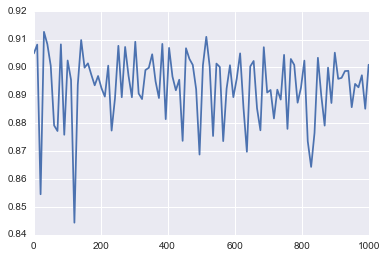

In [99]:
plt.plot(iters, accs)

## It seems that at a value of 10.101 for lambda, we obtain an accuracy of 91.27%. We seem to not have a converging accuracy bar, so the lambdas are random, which makes sense since we are using small batches for stochastic gradient descent.